In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
#from xgboost as

from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve, cross_val_score

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
testid = test['PassengerId']
train_len = len(train)

y = train['Survived']
X = pd.concat([train, test])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
X.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


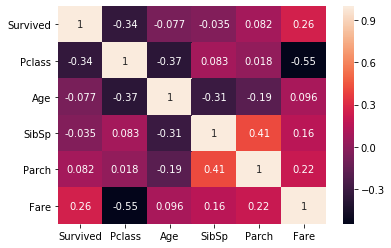

In [6]:
#data analysis
sns.heatmap(train[["Survived","Pclass","Age","SibSp","Parch","Fare"]].corr(), annot=True)

From the heatmap above, only the Fare correlated with the Survived Class. lets do another indepth analysis

## Age

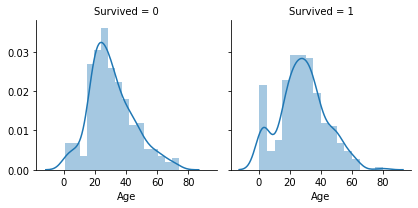

In [7]:
#indepth analsis
sns.FacetGrid(train, col='Survived').map(sns.distplot, "Age")

The age distribution is a Gaussian distribution.

The graphs show a peak in survival among young people. Unfortunately, elderly people have less chances to survive.
A jump in survival in children is also visible, which is quite logical. Most likely they were saved in the first place.

## SibSp

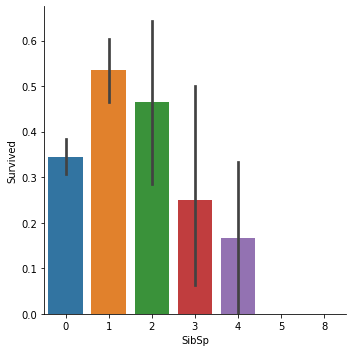

In [8]:
sns.catplot(x="SibSp", y="Survived", data=train, kind="bar")

This shows that people with fewer relatives are more likely to survive.

## Pclass

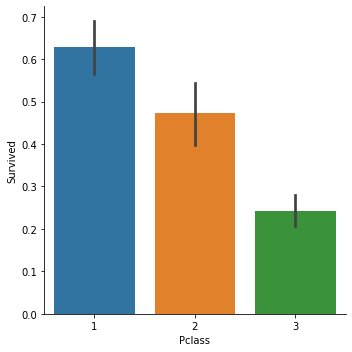

In [9]:
sns.catplot(x="Pclass", y="Survived", data=train, kind="bar")

First class passengers have more chance to survive than second class and third class passengers.

## Pclass X Age

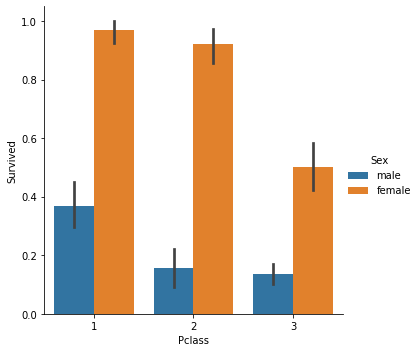

In [10]:
sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, kind="bar")

## Parch

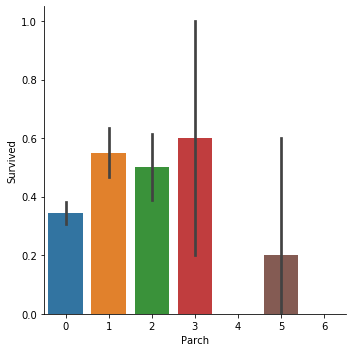

In [11]:
sns.catplot(x="Parch", y="Survived", data=train, kind="bar")

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6).

## Sex

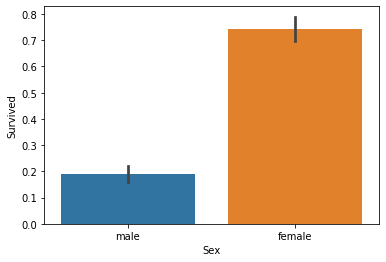

In [12]:
sns.barplot(x="Sex", y="Survived", data=train)

Men are less likely to survive than women

## Embarked

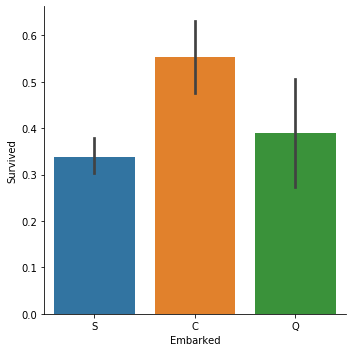

In [13]:
sns.catplot(x="Embarked", y="Survived", data=train, kind="bar")

A passenger arriving from Cherbourg (C) seems to be more likely to survive.

# Feature selection and enginnering

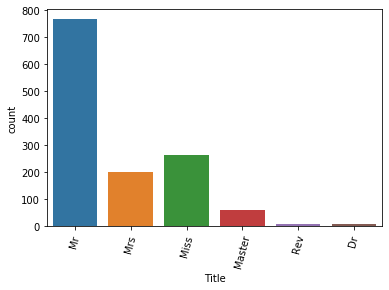

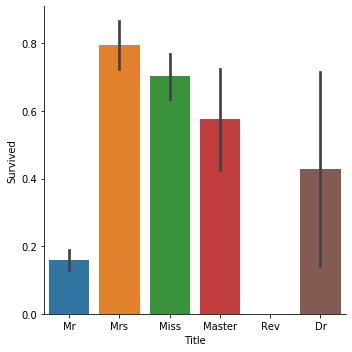

In [14]:
X['Title'] = X['Name']

for name_string in X['Name']:
    X['Title'] = X['Name'].str.extract('([A-Za-z]+)\.', expand=True)

mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}

X.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']

for title in titles:
    age_to_impute = X.groupby('Title')['Age'].median()[titles.index(title)]
    X.loc[(X['Age'].isnull()) & (X['Title'] == title), 'Age'] = age_to_impute

gr = sns.countplot(x="Title",data=X)
gr.set_xticklabels(gr.get_xticklabels(), rotation=75)
plt.show(gr)
sns.catplot(x="Title",y="Survived",data=X.iloc[:train_len],kind="bar")
plt.show(sns)    

X.drop('Title', axis = 1, inplace = True)

The Title feature was used for imputing age more precisely.

In [15]:
X['Family_Size'] = X['Parch'] + X['SibSp']

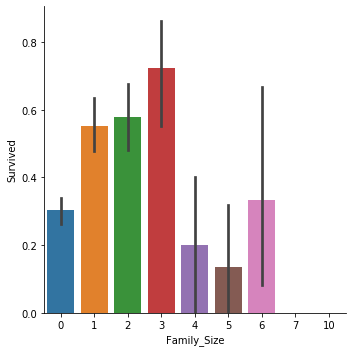

In [16]:
X['Last_Name'] = X['Name'].apply(lambda x: str.split(x, ",")[0])
X['Fare'].fillna(X['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
X['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in X[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                X.loc[X['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                X.loc[X['PassengerId'] == passID, 'Family_Survival'] = 0
                
for _, grp_df in X.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    X.loc[X['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    X.loc[X['PassengerId'] == passID, 'Family_Survival'] = 0
                        

sns.catplot(x="Family_Size",y="Survived",data = X.iloc[:train_len],kind="bar")

## Farebin

In [17]:
X['Fare'].fillna(X['Fare'].median(), inplace = True)

# Making Bins
X['FareBin'] = pd.qcut(X['Fare'], 5)

label = LabelEncoder()
X['FareBin_Code'] = label.fit_transform(X['FareBin'])

X.drop(['Fare'], 1, inplace=True)

## Agebin

In [18]:
X['AgeBin'] = pd.qcut(X['Age'], 4)

label = LabelEncoder()
X['AgeBin_Code'] = label.fit_transform(X['AgeBin'])

X.drop(['Age'], 1, inplace=True)

## Label encoding Sex

In [19]:
X['Sex'].replace(['male','female'],[0,1],inplace=True)


X.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked', 'Last_Name', 'FareBin', 'AgeBin', 'Survived'], axis = 1, inplace = True)

## Spliting data

In [20]:
X_train = X[:train_len]
X_test = X[train_len:]

y_train = y

## Scaling data

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Cross-Validation and Training

In [22]:
kfold = StratifiedKFold(n_splits=8)

## Random Forest Classifier

In [23]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [3,"sqrt", "log2"],
              "min_samples_split": [2, 4],
              "min_samples_leaf": [5, 7],
              "bootstrap": [False, True],
              "n_estimators" :[200, 500],
              "criterion": ["gini", "entropy"]}

rf_param_grid_best = {"max_depth": [None],
              "max_features": [3],
              "min_samples_split": [4],
              "min_samples_leaf": [5],
              "bootstrap": [False],
              "n_estimators" :[200],
              "criterion": ["gini"]}

gs_rf = GridSearchCV(RFC, param_grid = rf_param_grid_best, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gs_rf.fit(X_train, y_train)
RFC.fit(X_train, y_train)
rf_best = gs_rf.best_estimator_
print(f'RandomForest GridSearch best params: {gs_rf.best_params_}')
print(f'RandomForest GridSearch best score: {gs_rf.best_score_}')

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    5.6s finished


RandomForest GridSearch best params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 200}
RandomForest GridSearch best score: 0.8786249947363701


C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## K- Nearest Neighbor Classifier with euclidean distance

In [24]:
KNN = KNeighborsClassifier()

knn_param_grid = {'algorithm': ['auto'],
                 'weights': ['uniform', 'distance'], 
                 'leaf_size': [20, 25, 30], 
                 'n_neighbors': [12, 14, 16]}
gs_knn = GridSearchCV(KNN, param_grid = knn_param_grid, cv=kfold, scoring = "roc_auc", n_jobs= 4, verbose = 1)

gs_knn.fit(X_train, y_train)
KNN.fit(X_train, y_train)

knn_best = gs_knn.best_estimator_
print(f'KNN GridSearch best params: {gs_knn.best_params_}')
print(f'KNN GridSearch best score: {gs_knn.best_score_}')

Fitting 8 folds for each of 18 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KNN GridSearch best params: {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 16, 'weights': 'uniform'}
KNN GridSearch best score: 0.8740368856771839


[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:    0.3s finished


## Gradient Boosting Classifier

In [25]:
GB = GradientBoostingClassifier()

gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [1000],
              'learning_rate': [0.02, 0.05],
              'min_samples_split': [15, 20, 25],
              'max_depth': [4, 6],
              'min_samples_leaf': [50, 60],
              'max_features': ["sqrt"] 
              }

gb_param_grid_best = {'loss' : ["deviance"],
              'n_estimators' : [1000],
              'learning_rate': [0.02],
              'min_samples_split': [25],
              'max_depth': [4],
              'min_samples_leaf': [60],
              'max_features': ["sqrt"] 
              }

gs_gb = GridSearchCV(GB, param_grid = gb_param_grid_best, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gs_gb.fit(X_train,y_train)
GB.fit(X_train, y_train)

gb_best = gs_gb.best_estimator_
print(f'GradienBoost GridSearch best params: {gs_gb.best_params_}')
print(f'GradienBoost GridSearch best score: {gs_gb.best_score_}')

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    2.5s finished


GradienBoost GridSearch best params: {'learning_rate': 0.02, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'min_samples_split': 25, 'n_estimators': 1000}
GradienBoost GridSearch best score: 0.8873237161623463


## K- Nearest Neighbor Classifier with minkowski

In [26]:
knn1 = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')

knn1.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
                     metric_params=None, n_jobs=1, n_neighbors=6, p=2,
                     weights='uniform')

## Cross-val scores

In [28]:
def CVScore(classifiers):
    cv_score = []
    names = []
    for n_classifier in range(len(classifiers)):
        name = classifiers[n_classifier][0]
        model = classifiers[n_classifier][1]
        cv_score.append(cross_val_score(model, X_train, y_train, scoring = "roc_auc", cv = kfold, n_jobs=4))
        names.append(name)
    cv_means = []
    for cv_result in cv_score:
        cv_means.append(cv_result.mean())
        
    cv_res = pd.DataFrame({"Model":names,"CVMeans":cv_means})
    cv_res.sort_values("CVMeans", axis = 0, ascending = True, inplace = True)

    print('----------CrossVal scores---------\n', cv_res)

    
best_class = [("RandomForest", rf_best), ("GradientBoost", gb_best), ("KNN", knn_best),  ("KNN new", knn1)]


#CVScore(def_class)
CVScore(best_class)

----------CrossVal scores---------
            Model   CVMeans
3        KNN new  0.856871
2            KNN  0.874117
0   RandomForest  0.878063
1  GradientBoost  0.885883


Learning curves shows how well we are overfitting

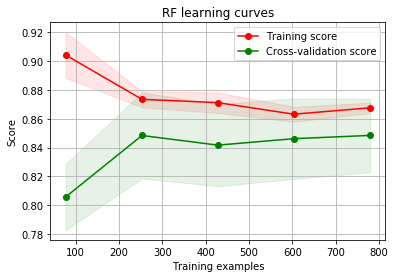

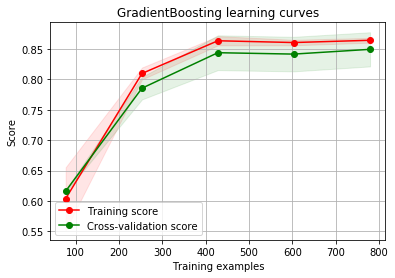

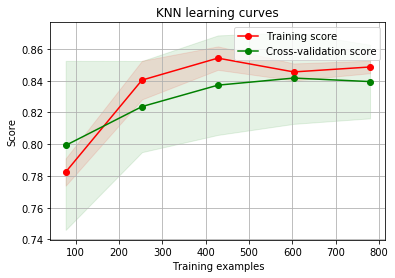

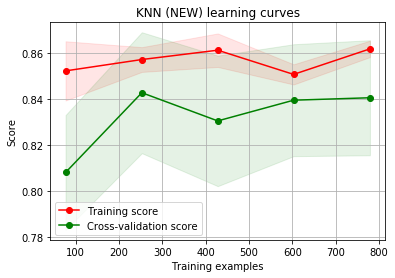

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

plot_learning_curve(rf_best,"RF learning curves", X_train, y_train, cv=kfold)
plot_learning_curve(gb_best,"GradientBoosting learning curves", X_train, y_train, cv=kfold)
plot_learning_curve(knn_best,"KNN learning curves", X_train, y_train, cv=kfold)
plot_learning_curve(knn1,"KNN (NEW) learning curves", X_train, y_train, cv=kfold)

From the learning curves above, Knn1(new) overfit the less

In [31]:
y_pred = knn1.predict(X_test)
test_Survived = pd.Series(y_pred, name="Survived")
results = pd.concat([testid,test_Survived],axis=1)
results.to_csv("submit.csv",index=False)